<span style="font-family: Open Sans; font-weight: 800; font-size: 40px; font-style: normal; text-align:center;">

Especialización Inteligecia Artificial - CEIA

</span>

<span style="font-family: Open Sans; font-weight: 700; font-size: 30px; font-style: normal; text-align:center;">

Aprendizaje de Máquinas

Trabajo práctico integrador

</span>

<span style="font-family: Open Sans; font-weight: 400; font-size: 20px; font-style: normal;">

<u>Autores</u>:
- Karen Raczkowski @raczki
- Juan Ignacio Ribet @Juaniribet
- Martín Caceres
- FS @BenjaSar

</span>

## Tabla de contenido
----

1. [Planteamiento del problema](#1-planteamiento-del-problema)<br>
1.1 [Lego database](#11-lego-database)<br>
1.2 [Importación de las librerías necesarias](#importación-de-las-librerías-necesarias-para-el-trabajo)<br>
2. [Análisis básicos de los *datasets*](#análisis-básico-de-los-datasets)<br>
3. [¿Como evolucionaron los *sets* de lego en tamñao a través de los años](#3-¿cómo-evolucionaron-los-sets-de-lego-en-tamaño-a-través-de-los-años)<br>
4. [¿Podría predecir a que temática pertenece un set basado en el contenido de este](#¿podría-predecir-a-que-temática-pertenece-un-set-basado-en-el-contenido-de-este)<br>
4.1 [Reducción de dimensionalidad](#5-reducción-de-dimensionalidad)<br>
4.2 [Análisis exploratorio](#42-análisis-exploratorio)<br>
4.3 [Tipos de variables](#43-tipos-de-variables)<br>
4.4 [Análsis de temáticas y colores más comunes](#44-análisis-de-temáticas-y-colores-más-comunes)<br>
4.5 [Análisis de categorías de piezas](#45-análisis-de-categorías-de-piezas)<br>
4.6 [Preparación de features](#46-preparación-de-features)<br>
4.7 [Selección de features](#47-selección-de-features)<br>
5. [Licencia](#Licencia)


<span style="font-family: Open Sans; font-weight: 400; font-size: 19px; font-style: normal">

## 1. Planteamiento del problema
---

### 1.1 **LEGO database**

 - ¿Cómo evolucionaron los sets de lego en tamaño a través de los años?
 - ¿Podría predecir a que temática pertenece un set basado en el contenido de este?

 </span>
 

 ![Data set Schema](https://rebrickable.com/static/img/diagrams/downloads_schema_v3.png)

<span style="font-family: Open Sans; font-weight: 100; font-size: 19px; font-style: normal;">

Para responder las preguntas planteadas vamos a utilizar los siguientes datasets que nos van a dar la información de lo que contiene cada set de Lego:

- themes
- sets
- inventories
- inventory_parts
- colors
- parts
- part_categories

</span>

#### 1.2 Importación de las librerías necesarias para el trabajo.

In [1]:
# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats
import plotly.express as px

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

#Categorical transformations
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder


# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Training schemas
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold

from functools import reduce

from sklearn.feature_extraction import FeatureHasher

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [2]:
#Creamos los DataFrames

df = pd.read_csv("./data/df_encoded.csv", delimiter=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   quantity_part                                 6732 non-null   int64  
 1   negro                                         6732 non-null   float64
 2   gris                                          6732 non-null   float64
 3   blanco                                        6732 non-null   float64
 4   gris_2                                        6732 non-null   float64
 5   rojo                                          6732 non-null   float64
 6   azul                                          6732 non-null   float64
 7   amarillo                                      6732 non-null   float64
 8   beige                                         6732 non-null   float64
 9   gris_3                                        6732 non-null   f

```Inventory_parts```: Este dataset contiene información sobre los inventarios de piezas, incluido un número de identificación único ("inventory_id"), el número de pieza ("part_num"), el color de la pieza ("color_id"), cuántas de ellas se incluyen ("quantity") y si se trata de un repuesto ("is_spare").

```Parts```: Este dataset incluye información sobre piezas de lego, incluido un número de identificación único para cada pieza ("part_num"), el nombre de la pieza ("name"), la categoría de la que proviene ("part_cat_id") y su material ("part_material").

```Colors```: Esta data contiene información sobre los colores de LEGO, incluida una identificación única para cada color ("id"), su nombre ("name") y el valor RGB aproximado ("rgb"), y si es transparente ("is_trans").

```Part_categories```: Este dataset incluye información sobre la categoría de la pieza ("name") y una identificación única para esa categoría de pieza ("id").

## 4. ¿Podría predecir a que temática pertenece un set basado en el contenido de este?
---
Para responder esta pregunta vamos a unir los DataFrames para poder obtener información sobre qué piezas contiene cada set y las características de las mismas.

Antes de eso, vamos a realizar una exploracion de los datasets con un ejemplo para poder entender cómo obtener la información.

In [34]:
#Buscamos un ejemplo de set en 'sets', elegimos un set icónico como es la torre Eiffel.
sets[sets['set_num'] == '10307-1']

,set_num,name,year,theme_id,num_parts,img_url
399,10307-1,Eiffel Tower,2022,721,10001,https://cdn.rebrickable.com/media/sets/10307-1...


<img src="https://cdn.rebrickable.com/media/sets/10307-1.jpg"  width="300" height="600">

In [61]:
df_qp = df_final[['quantity_part', 'themes_parent_name']]
group_df_qp = df_qp.groupby('themes_parent_name').sum().reset_index()
aggregated_df_qp = group_df_qp.sort_values('quantity_part', ascending=False)

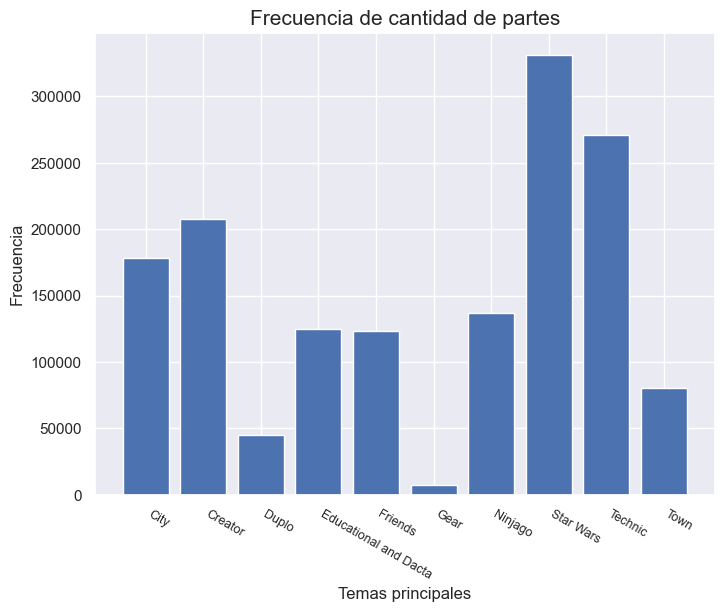

In [62]:
top_theme= 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(group_df_qp['themes_parent_name'][:top_theme], group_df_qp['quantity_part'][:top_theme])
ax.set_xlabel('Temas principales')
ax.set_ylabel('Frecuencia')
ax.set_title("Frecuencia de cantidad de partes", fontsize = 15)
#ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

Vemos que el feature 'Gear' no cuenta con alta representación dentro de los diez primeros features evaluados. Además, estos sets corresponden a piezas de accesorios (por ejemplo, llaveros). Por este último motivo, se decide descartar el tema 'Gear' del dataset final.

In [63]:
grouped_df = grouped_df[~grouped_df['themes_parent_name'].isin(['Gear'])]

In [64]:
df_final = df_final_completo[df_final_completo['themes_parent_name'].isin(grouped_df['themes_parent_name'].value_counts()[:top_tematica].index)]

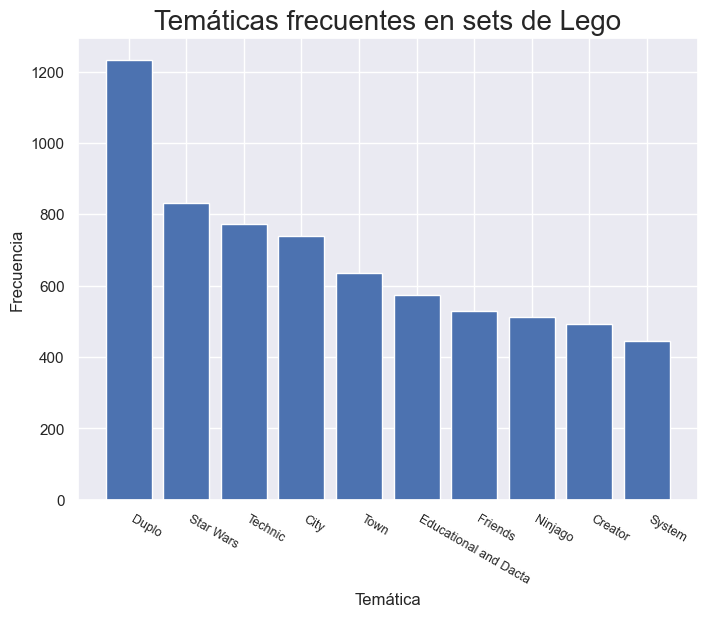

In [65]:
top_tematica = 10

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(grouped_df['themes_parent_name'].value_counts()[:top_tematica].index, grouped_df['themes_parent_name'].value_counts()[:top_tematica])
ax.set_xlabel('Temática')
ax.set_ylabel('Frecuencia')
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
ax.set_title("Temáticas frecuentes en sets de Lego", fontsize = 20)
plt.show()

In [66]:
df_qp = df_final[['quantity_part', 'themes_parent_name']]
group_df_qp = df_qp.groupby('themes_parent_name').sum().reset_index()
aggregated_df_qp = group_df_qp.sort_values('quantity_part', ascending=False)

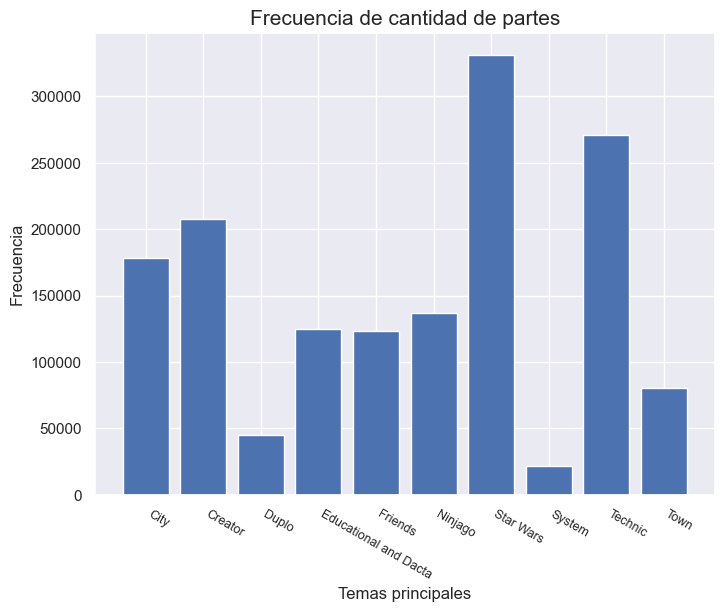

In [67]:
top_theme= 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(group_df_qp['themes_parent_name'][:top_theme], group_df_qp['quantity_part'][:top_theme])
ax.set_xlabel('Temas principales')
ax.set_ylabel('Frecuencia')
ax.set_title("Frecuencia de cantidad de partes", fontsize = 15)
#ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

Se decide descartar 'System', ya que dejó de fabricarse en los 70s.

In [68]:
grouped_df = grouped_df[~grouped_df['themes_parent_name'].isin(['System'])]

In [69]:
df_final = df_final_completo[df_final_completo['themes_parent_name'].isin(grouped_df['themes_parent_name'].value_counts()[:top_tematica].index)]

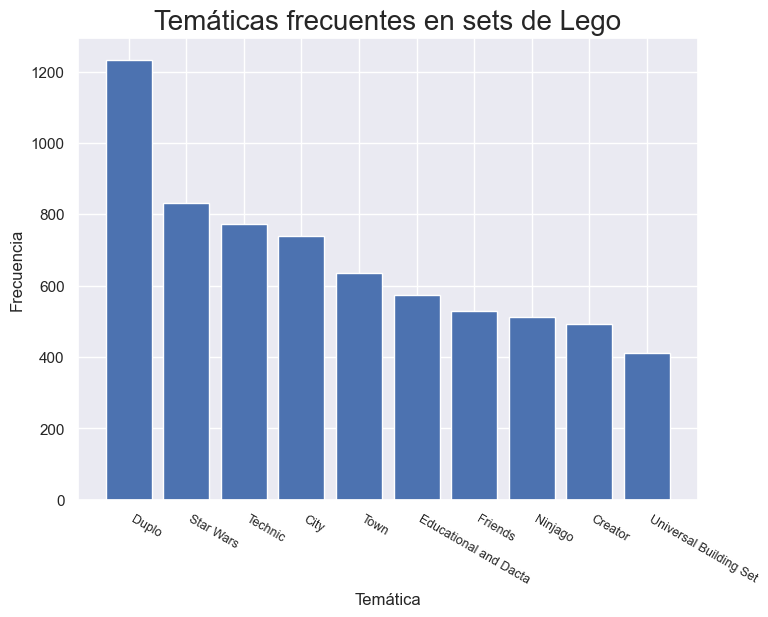

In [70]:
top_tematica = 10

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(grouped_df['themes_parent_name'].value_counts()[:top_tematica].index, grouped_df['themes_parent_name'].value_counts()[:top_tematica])
ax.set_xlabel('Temática')
ax.set_ylabel('Frecuencia')
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
ax.set_title("Temáticas frecuentes en sets de Lego", fontsize = 20)
plt.show()

In [71]:
df_qp = df_final[['quantity_part', 'themes_parent_name']]
group_df_qp = df_qp.groupby('themes_parent_name').sum().reset_index()
aggregated_df_qp = group_df_qp.sort_values('quantity_part', ascending=False)

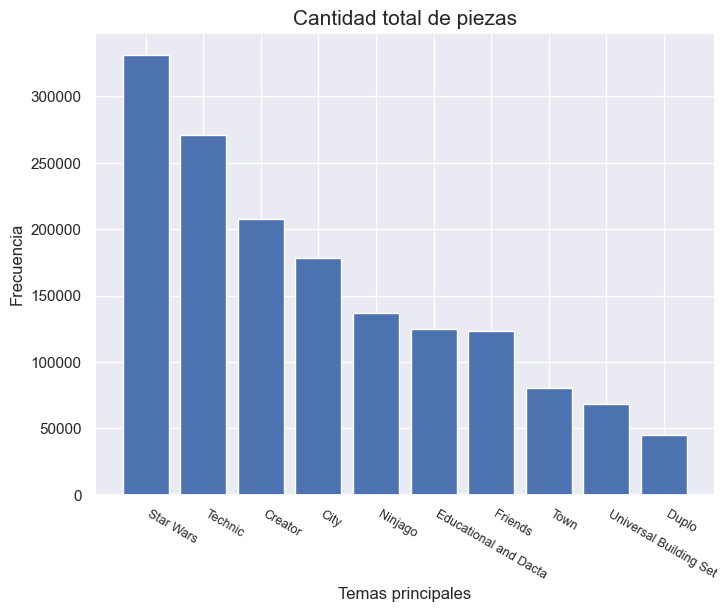

In [72]:
top_theme= 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(aggregated_df_qp['themes_parent_name'][:top_theme], aggregated_df_qp['quantity_part'][:top_theme])
ax.set_xlabel('Temas principales')
ax.set_ylabel('Frecuencia')
ax.set_title("Cantidad total de piezas", fontsize = 15)
#ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

In [73]:
aggregated_df_qp = group_df_qp.groupby('themes_parent_name').mean().reset_index().sort_values('quantity_part', ascending=False)
aggregated_df_qp

,themes_parent_name,quantity_part
6,Star Wars,331102.0
7,Technic,270524.0
1,Creator,207709.0
0,City,178200.0
5,Ninjago,137132.0
3,Educational and Dacta,124927.0
4,Friends,123362.0
8,Town,80053.0
9,Universal Building Set,68623.0
2,Duplo,44822.0


In [74]:
df_qp = df_final[['set_num', 'quantity_part', 'themes_parent_name']]
group_df_qp = df_qp.groupby(['set_num', 'themes_parent_name']).sum().reset_index()
group_df_qp = group_df_qp[['quantity_part', 'themes_parent_name']]
group_df_qp = group_df_qp.groupby(['themes_parent_name']).mean().reset_index()
group_df_qp = group_df_qp.sort_values('quantity_part', ascending=False)

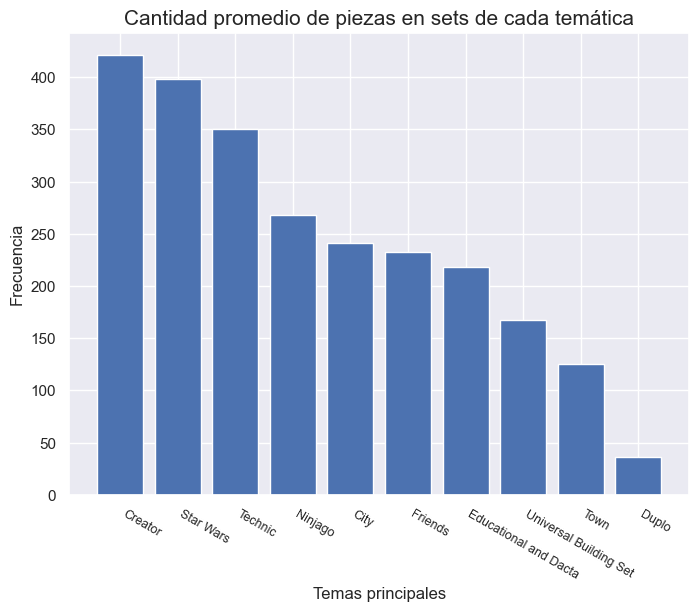

In [75]:
top_theme= 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(group_df_qp['themes_parent_name'][:top_theme], group_df_qp['quantity_part'][:top_theme])
ax.set_xlabel('Temas principales')
ax.set_ylabel('Frecuencia')
ax.set_title("Cantidad promedio de piezas en sets de cada temática", fontsize = 15)
#ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

In [76]:
#Dejamos solo las variables que nos interesan y eliminamos el resto
df_final = df_final.drop(columns=['id','version','color_id', 'is_spare', 'name', 'part_cat_id'])
# Agregar un numeral a los rgb para graficarlos
df_final['rgb'] = df_final['rgb'].apply(lambda x : '#'+x)
df_final

,set_num,themes_parent_name,part_num,quantity_part,rgb,part_material,cat_name
13,3931-1,Friends,2343,1,#FCFCFC,Plastic,Minifig Accessories
16,41135-1,Friends,2343,2,#FCFCFC,Plastic,Minifig Accessories
17,1821-1,Town,2343,4,#9BA19D,Plastic,Minifig Accessories
18,1821-1,Town,2343,1,#F2CD37,Plastic,Minifig Accessories
26,3040-1,Universal Building Set,2343,1,#FCFCFC,Plastic,Minifig Accessories
...,...,...,...,...,...,...,...
1083529,10997-1,Duplo,102287pr0001,1,#EBD800,Plastic,"Non-Buildable Figures (Duplo, Fabuland, etc)"
1083530,10997-1,Duplo,102287pr0002,1,#EBD800,Plastic,"Non-Buildable Figures (Duplo, Fabuland, etc)"
1083531,10997-1,Duplo,102287pr0003,1,#EBD800,Plastic,"Non-Buildable Figures (Duplo, Fabuland, etc)"
1083532,10997-1,Duplo,3437pr0175,1,#FCFCFC,Plastic,"Duplo, Quatro and Primo"


### 4.2 Análisis exploratorio

A continuación se hace un análisis de las variables que componen el dataset **df_final**

### 4.3 Tipos de variables 

In [77]:
# Obtener los nombres de las columnas categóricas
cat_cols = df_final.select_dtypes(include='object').columns
print("Variables categóricas en el dataset:")
for col in cat_cols:
    print(col)

Variables categóricas en el dataset:
set_num
themes_parent_name
part_num
rgb
part_material
cat_name


Donde todas las variables descriptas anteriormente son del tipo nominal.

In [78]:
# Obtener los nombres de las columnas numéricas
num_cols = df_final.select_dtypes(include='number').columns
print("Variables numéricas en el dataset:")
for col in num_cols:
    print(col)

Variables numéricas en el dataset:
quantity_part


En forma resumida, las variables encontradas en el dataset son:

**Categóricas**
* set_num
* themes_parent_name
* part_num
* rgb
* part_material
* cat_name

**Numéricas**
* quantity_part

In [79]:
# Separar las variables numéricas y categóricas
num_data = df_final.loc[:, ["quantity_part"]]
cat_data = df_final.drop(['quantity_part'], axis=1)

In [80]:
# Resumen de 5 números de var numerica
resumen = num_data.describe()
print(resumen)

       quantity_part
count  454798.000000
mean        3.444285
std         8.247548
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       724.000000


In [81]:
print(aggregated_df_qp)

       themes_parent_name  quantity_part
6               Star Wars       331102.0
7                 Technic       270524.0
1                 Creator       207709.0
0                    City       178200.0
5                 Ninjago       137132.0
3   Educational and Dacta       124927.0
4                 Friends       123362.0
8                    Town        80053.0
9  Universal Building Set        68623.0
2                   Duplo        44822.0


In [82]:
# Verificar si hay valores faltantes
missing_values_count = df_final.isnull().sum()
non_zero_missing_num = missing_values_count[missing_values_count != 0]

print("Variables con missing values:")
if non_zero_missing_num.empty:
    print("0")
else:
    for variable, count in non_zero_missing_num.items():
        print(f"{variable}: {count}")

Variables con missing values:
0


In [83]:
# Exploraración de las variables categóricas
for col in cat_data:
    print(f"Classes in {col}:")
    print(df_final[col].value_counts())
    print('\n')

Classes in set_num:
set_num
71799-1     1484
71741-1     1309
70620-1     1013
75331-1      801
75192-1      730
            ... 
970632-1       1
302-2          1
553-1          1
813-1          1
970611-1       1
Name: count, Length: 6732, dtype: int64


Classes in themes_parent_name:
themes_parent_name
Star Wars                 83725
City                      76897
Friends                   55936
Creator                   49394
Ninjago                   46715
Technic                   44987
Town                      35020
Educational and Dacta     24903
Duplo                     23360
Universal Building Set    13861
Name: count, dtype: int64


Classes in part_num:
part_num
6141           12003
3023            7878
54200           6055
3024            5812
3710            5357
               ...  
4215apr0018        1
3596pr0004         1
24526              1
17591              1
76371pr0216        1
Name: count, Length: 15298, dtype: int64


Classes in rgb:
rgb
#05131D    78792
#FFF

### 4.4 Análisis de piezas en cada temática

In [84]:
df_qp = df_final[['set_num', 'quantity_part', 'themes_parent_name']]
group_df_qp = df_qp.groupby(['themes_parent_name', 'set_num']).sum().reset_index()
distribution_metrics = group_df_qp.groupby('themes_parent_name')['quantity_part'].agg(['min', 'max', 'mean', 'median','std','var'])
print(distribution_metrics)

                        min   max        mean  median         std   
themes_parent_name                                                  
City                      1  1949  241.136671   151.0  268.437351  \
Creator                   1  5962  421.316430   200.0  677.073393   
Duplo                     1   387   36.351987    25.0   38.204882   
Educational and Dacta     1  4900  218.022688    83.0  440.073859   
Friends                   1  2074  232.758491    95.0  296.843594   
Ninjago                   1  6230  267.835938    62.5  562.005001   
Star Wars                 1  7663  397.959135   165.5  705.573794   
Technic                   1  4134  350.419689   121.0  574.583738   
Town                      2  2059  125.671900    66.0  164.090453   
Universal Building Set    1  1201  166.965937    52.0  227.600535   

                                  var  
themes_parent_name                     
City                     72058.611377  
Creator                 458428.379343  
Duplo      

### 4.5 Análisis de colores más comunes y materiales

In [85]:
print(f"Hay {df_final['part_material'].nunique()} materiales distintos en el dataset")

Hay 5 materiales distintos en el dataset


In [86]:
print(f"Hay {df_final['rgb'].nunique()} colores distintos en el dataset")

Hay 129 colores distintos en el dataset


In [57]:
# Vemos cuántas observaciones (tipo de pieza) de cada color hay en los datos
subset_df = df_final[['quantity_part', 'rgb']]
aggregated_df = subset_df.groupby('rgb').count().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
aggregated_df.head(10)

,rgb,quantity_part
5,#05131D,78785
128,#FFFFFF,56820
58,#A0A5A9,54980
84,#C91A09,41746
34,#6C6E68,38217
108,#F2CD37,28105
1,#0055BF,20247
102,#E4CD9E,12293
55,#9BA19D,11994
24,#582A12,11345


In [87]:
# Vemos cuántas piezas de cada color hay en los datos
subset_df = df_final[['quantity_part', 'rgb']]
aggregated_df = subset_df.groupby('rgb').sum().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
aggregated_df.head(10)

,rgb,quantity_part
5,#05131D,298131
58,#A0A5A9,202728
128,#FFFFFF,186178
84,#C91A09,139596
34,#6C6E68,133441
1,#0055BF,95519
108,#F2CD37,90863
102,#E4CD9E,48048
55,#9BA19D,47166
24,#582A12,36408


In [88]:
df_qp = df_final[['set_num', 'quantity_part', 'rgb']]
group_df_qp = df_qp.groupby(['set_num', 'rgb']).sum().reset_index()
distribution_metrics = group_df_qp.groupby('rgb')['quantity_part'].agg(['min', 'max', 'mean', 'median','std','var'])
print(distribution_metrics)

         min   max       mean  median         std           var
rgb                                                            
#0020A0    1   117   6.391089     3.0   10.376937    107.680813
#0055BF    1   633  25.892925     8.0   52.912743   2799.758326
#0059A3    1     1   1.000000     1.0    0.000000      0.000000
#008F9B    1   174  16.202247     7.0   25.016617    625.831123
#009ECE    1     2   1.200000     1.0    0.447214      0.200000
...      ...   ...        ...     ...         ...           ...
#FFA70B    1    16   3.632653     2.0    4.116501     16.945578
#FFCB78    1     1   1.000000     1.0         NaN           NaN
#FFF03A    1   382   8.210191     3.0   24.331452    592.019576
#FFF230    5     5   5.000000     5.0         NaN           NaN
#FFFFFF    1  3548  42.779871    13.0  111.776609  12494.010369

[129 rows x 6 columns]


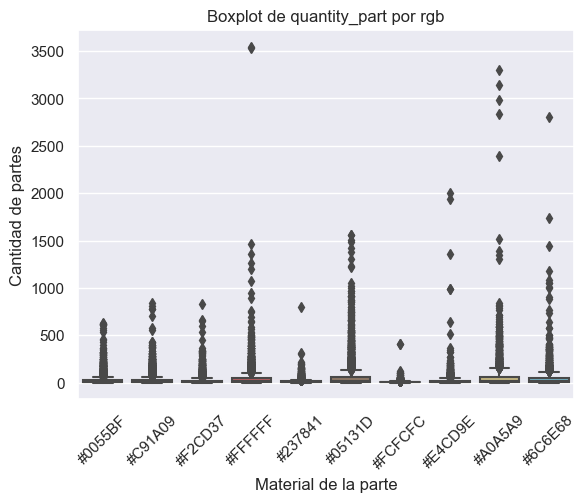

In [89]:
top_colores = 10
colores_grafico = group_df_qp['rgb'].value_counts()[:top_colores].index
df_filtered = group_df_qp[group_df_qp['rgb'].isin(colores_grafico)]
# Crear el boxplot utilizando seaborn
sns.boxplot(x="rgb", y="quantity_part", data=df_filtered)
plt.title("Boxplot de quantity_part por rgb")
plt.xlabel("Material de la parte")
plt.ylabel("Cantidad de partes")
plt.xticks(rotation=45) 
plt.show()

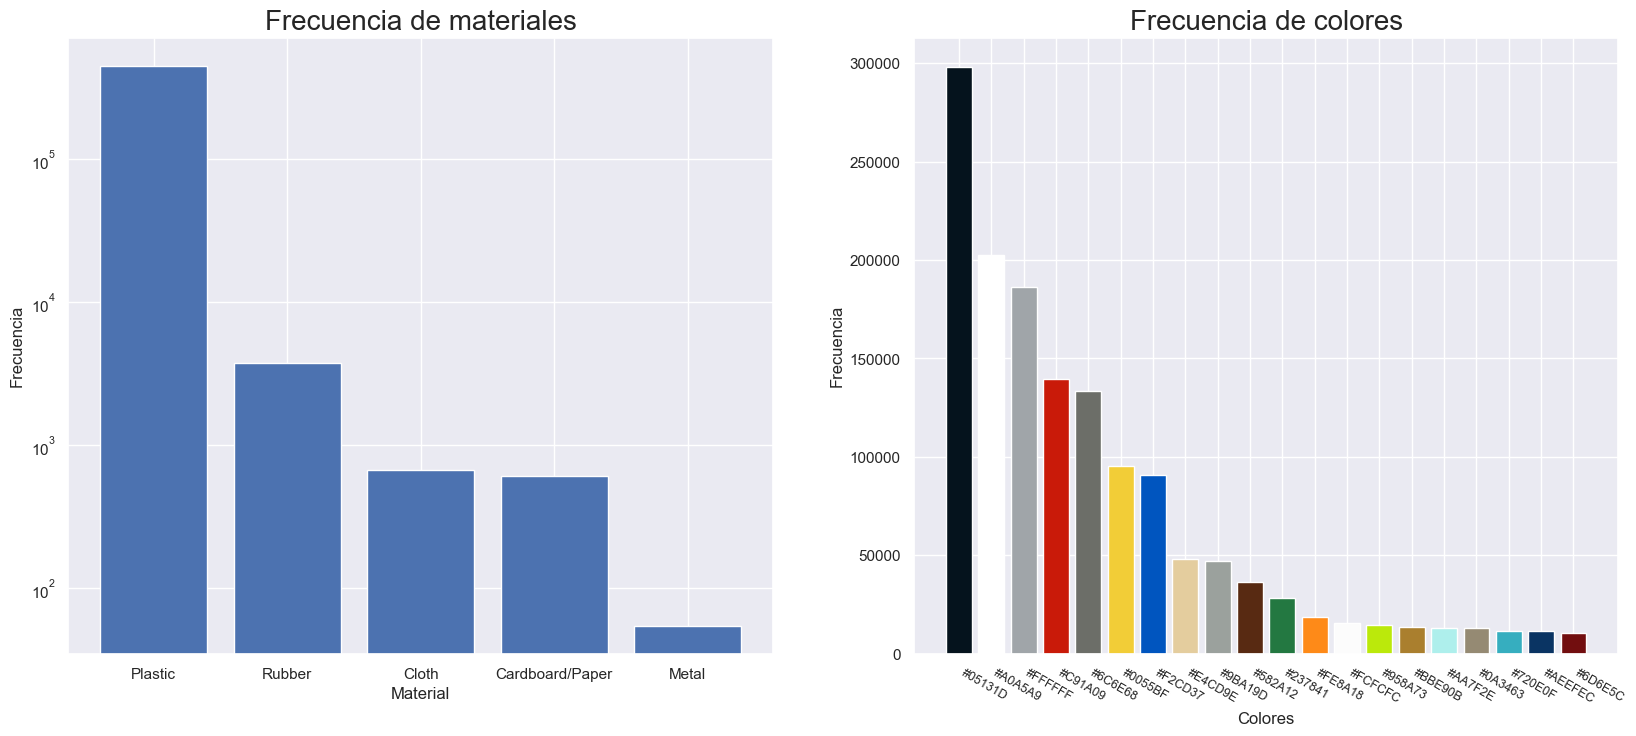

In [90]:
top_colores = 20
colores_grafico = df_final['rgb'].value_counts()[:top_colores].index

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].bar(df_final['part_material'].value_counts().index, df_final['part_material'].value_counts())
ax[0].set_xlabel('Material')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title("Frecuencia de materiales", fontsize = 20)
ax[0].set_yscale('log')

ax[1].bar(aggregated_df['rgb'][:top_colores], aggregated_df['quantity_part'][:top_colores], color=colores_grafico)
ax[1].set_xlabel('Colores')
ax[1].set_ylabel('Frecuencia')
ax[1].set_title("Frecuencia de colores", fontsize = 20)

plt.setp(ax[1].get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

In [91]:
# Vemos cuántas tipos de piezas de cada material hay en los datos
subset_df = df_final[['quantity_part', 'part_material']]
aggregated_df = subset_df.groupby('part_material').count().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
aggregated_df.head(10)

,part_material,quantity_part
3,Plastic,449726
4,Rubber,3728
1,Cloth,677
0,Cardboard/Paper,612
2,Metal,55


In [92]:
# Vemos cuántas piezas de cada material hay en los datos
subset_df = df_final[['quantity_part', 'part_material']]
aggregated_df = subset_df.groupby('part_material').sum().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
aggregated_df.head(10)

,part_material,quantity_part
3,Plastic,1548980
4,Rubber,15796
1,Cloth,856
0,Cardboard/Paper,621
2,Metal,201


In [93]:
df_qp = df_final[['set_num', 'quantity_part', 'part_material']]
group_df_qp = df_qp.groupby(['set_num', 'part_material']).sum().reset_index()
distribution_metrics = group_df_qp.groupby('part_material')['quantity_part'].agg(['min', 'max', 'mean', 'median','std','var'])
print(distribution_metrics)

                 min   max        mean  median         std            var
part_material                                                            
Cardboard/Paper    1    21    3.568966     2.0    3.415937      11.668627
Cloth              1    40    1.718876     1.0    2.453037       6.017389
Metal              1    18    3.722222     1.5    4.044174      16.355346
Plastic            1  7662  230.777712    72.0  457.671161  209462.891424
Rubber             1   144    6.670608     4.0    7.801971      60.870754


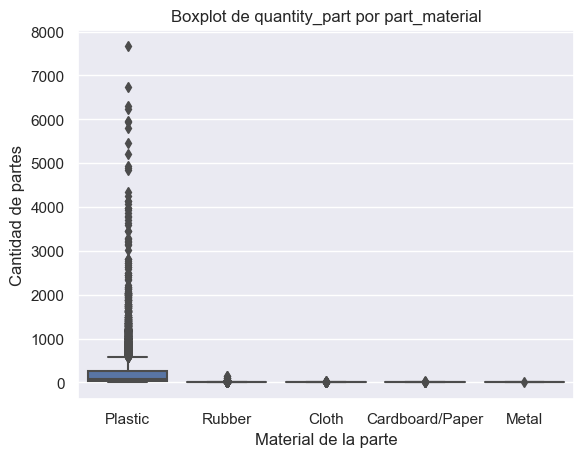

In [94]:
# Crear el boxplot utilizando seaborn
sns.boxplot(x="part_material", y="quantity_part", data=group_df_qp)
plt.title("Boxplot de quantity_part por part_material")
plt.xlabel("Material de la parte")
plt.ylabel("Cantidad de partes")
plt.show()

A continuación se analizan los colores en cada temática

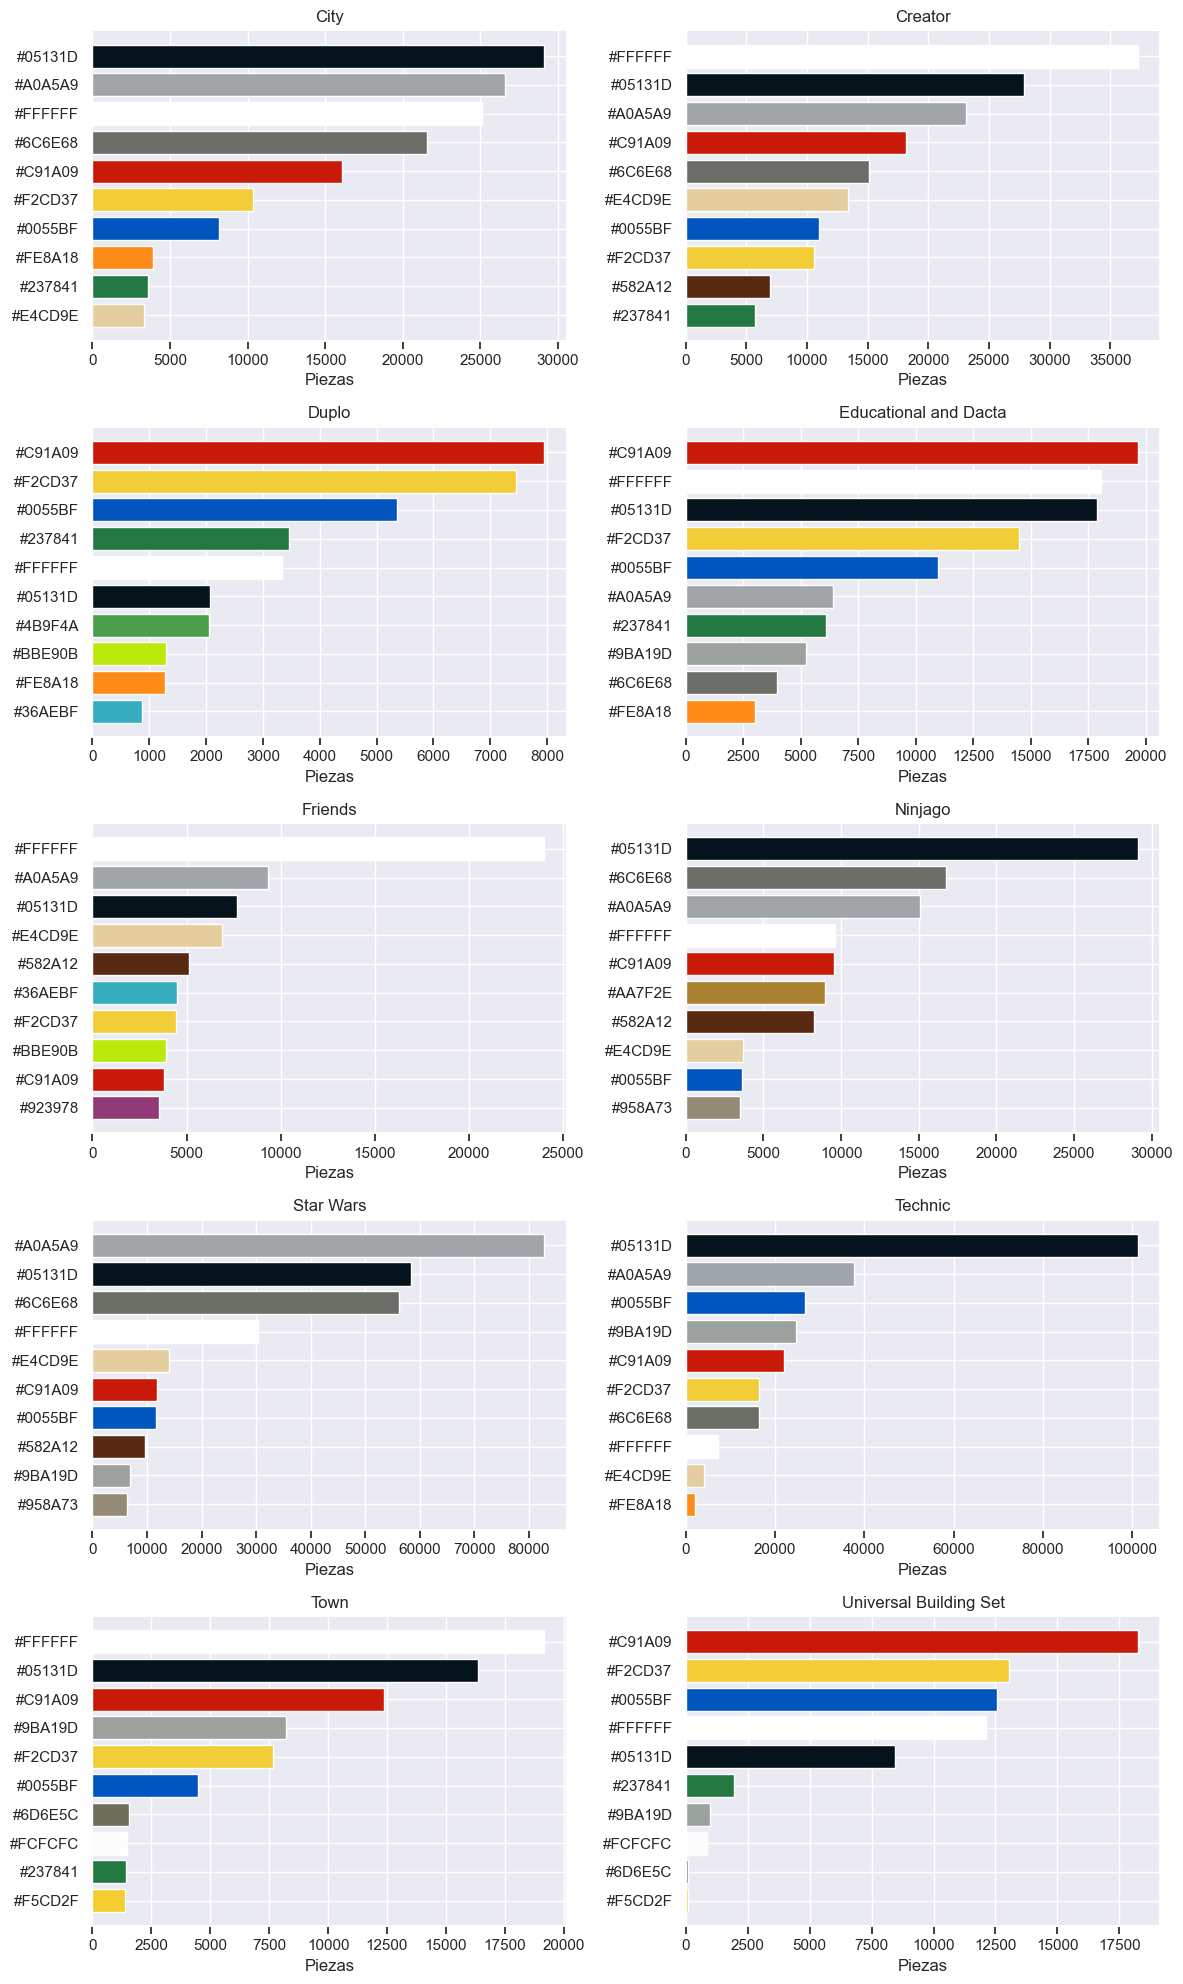

In [95]:
# Elegir cuántos colores visualizar
top_colors = 10

# Agrupar y sumar piezas de cada color dentro de cada tema y quedarse con los colores con más piezas 
theme_color_counts = df_final.groupby(['themes_parent_name', 'rgb'])['quantity_part'].sum().reset_index()
top_10_colors = theme_color_counts.groupby('themes_parent_name').apply(lambda x: x.nlargest(top_colors, 'quantity_part')).reset_index(drop=True)

# Extraer los nombres de las temáticas y RGB únicos
grouped_data = top_10_colors.groupby('themes_parent_name')
theme_names = list(grouped_data.groups.keys())

top_10_rgb_codes = {}
for theme_name, group in grouped_data:
    sorted_data = group.sort_values(by='quantity_part', ascending=False)
    top_10_data = sorted_data.head(10)
    top_10_rgb_codes[theme_name] = top_10_data['rgb'].tolist()

# Bar charts
num_charts = len(theme_names)
num_cols = 2
num_rows = (num_charts + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), sharex=False)

for i, theme_name in enumerate(theme_names):
    row = i // num_cols
    col = i % num_cols

    theme_rgb_codes = top_10_rgb_codes[theme_name]
    group = grouped_data.get_group(theme_name)
    frequencies = group.loc[group['rgb'].isin(theme_rgb_codes), 'quantity_part']
    colors = group.loc[group['rgb'].isin(theme_rgb_codes), 'rgb']

    y_pos = np.arange(len(frequencies))
    axs[row, col].barh(y_pos, frequencies, align='center', color=colors)
    axs[row, col].set_yticks(y_pos)
    axs[row, col].set_yticklabels(colors)
    axs[row, col].invert_yaxis()
    axs[row, col].set_xlabel('Piezas')
    axs[row, col].set_title(theme_name)

    # Create a twin Axes object for separate x-axis scale
    axs_twin = axs[row, col].twiny()

    # Adjust x-axis limits
    max_frequency = max(frequencies)
    axs_twin.set_xlim([0, max_frequency * 1.1])  # Add a buffer of 10% to the maximum frequency for better visibility

    # Remove ticks and labels from the twin Axes
    axs_twin.set_xticks([])
    axs_twin.set_xticklabels([])

# Hide unused subplots
if num_charts < num_rows * num_cols:
    for i in range(num_charts, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

### 4.5 Análisis de categorías de piezas

In [96]:
print(f"Hay {df_final['cat_name'].nunique()} nombres de categorías de piezas distintas en el dataset")

Hay 63 nombres de categorías de piezas distintas en el dataset


In [97]:
subset_df = df_final[['quantity_part', 'cat_name']]
aggregated_df = subset_df.groupby('cat_name').sum().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
print(aggregated_df)

               cat_name  quantity_part
32               Plates         225691
3                Bricks         194344
50         Technic Pins         120202
35       Plates Special         103863
6         Bricks Sloped          86258
..                  ...            ...
29                Other             21
18       Minidoll Heads             14
13             HO Scale              6
20  Minidoll Upper Body              6
19  Minidoll Lower Body              3

[63 rows x 2 columns]


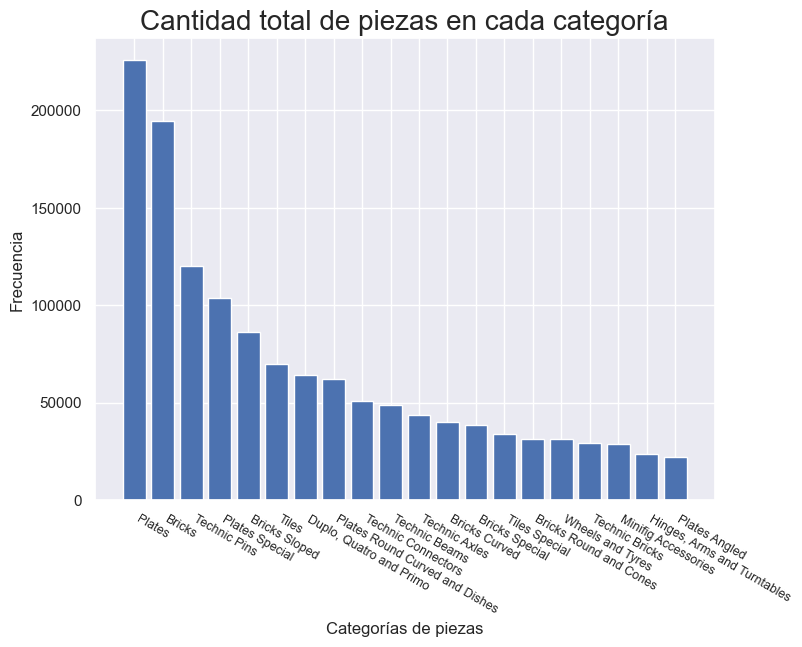

In [98]:
top_cat = 20

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(aggregated_df['cat_name'][:top_cat], aggregated_df['quantity_part'][:top_cat])
ax.set_xlabel('Categorías de piezas')
ax.set_ylabel('Frecuencia')
ax.set_title("Cantidad total de piezas en cada categoría", fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

In [99]:
df_qp = df_final[['set_num', 'quantity_part', 'cat_name']]
group_df_qp = df_qp.groupby(['set_num', 'cat_name']).sum().reset_index()
group_df_qp = group_df_qp[['quantity_part', 'cat_name']]
group_df_qp = group_df_qp.groupby(['cat_name']).mean().reset_index()
group_df_qp = group_df_qp.sort_values('quantity_part', ascending=False)

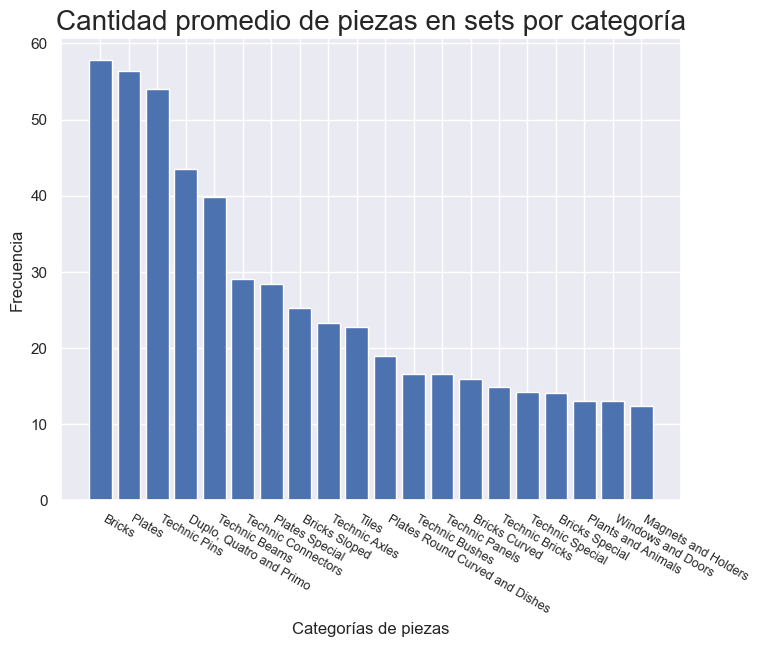

In [100]:
top_cat = 20

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(group_df_qp['cat_name'][:top_cat], group_df_qp['quantity_part'][:top_cat])
ax.set_xlabel('Categorías de piezas')
ax.set_ylabel('Frecuencia')
ax.set_title("Cantidad promedio de piezas en sets por categoría", fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=9, rotation=330, ha='left')
plt.show()

In [101]:
df_qp = df_final[['set_num', 'quantity_part', 'cat_name']]
group_df_qp = df_qp.groupby(['set_num', 'cat_name']).sum().reset_index()
distribution_metrics = group_df_qp.groupby('cat_name')['quantity_part'].agg(['min', 'max', 'mean', 'median','std','var'])
print(distribution_metrics)

                              min   max       mean  median         std   
cat_name                                                                 
Bars, Ladders and Fences        1   294   7.760965     4.0   14.550745  \
Baseplates                      1    50   2.386301     1.0    3.998809   
Belville, Scala and Fabuland    1     4   1.470588     1.0    0.874475   
Bricks                          1  2100  57.788879    12.0  145.232520   
Bricks Curved                   1   409  15.896063     8.0   24.887352   
...                           ...   ...        ...     ...         ...   
Transportation - Sea and Air    1   100   3.621901     3.0    4.267384   
Tubes and Hoses                 1   338   5.889680     2.0   18.743277   
Wheels and Tyres                1   288  12.112269     8.0   14.012680   
Windows and Doors               1   260  13.036645     6.0   18.791685   
Windscreens and Fuselage        1    27   2.144658     1.0    2.063157   

                                     

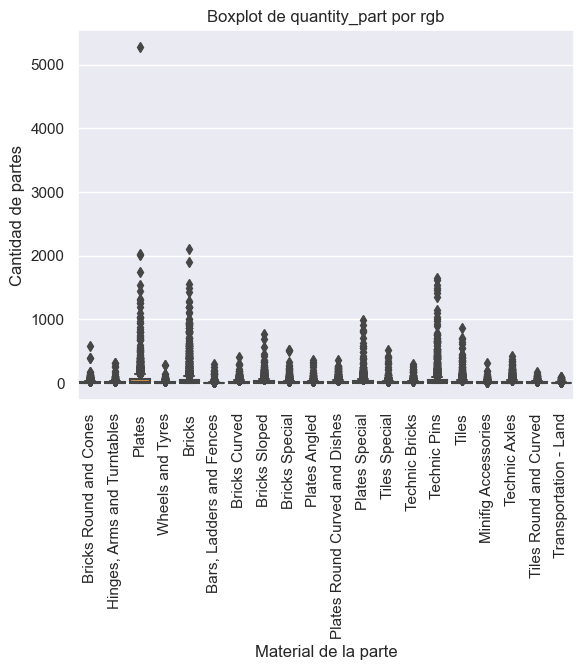

In [102]:
top_cat = 20
colores_grafico = group_df_qp['cat_name'].value_counts()[:top_cat].index
df_filtered = group_df_qp[group_df_qp['cat_name'].isin(colores_grafico)]
# Crear el boxplot utilizando seaborn
sns.boxplot(x="cat_name", y="quantity_part", data=df_filtered)
plt.title("Boxplot de quantity_part por rgb")
plt.xlabel("Material de la parte")
plt.ylabel("Cantidad de partes")
plt.xticks(rotation=90) 
plt.show()

### 4.6 Preparación de features

In [103]:
df_final_modelo = df_final.copy()

In [104]:
subset_df = df_final[['quantity_part', 'rgb']]
aggregated_df = subset_df.groupby('rgb').sum().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
aggregated_df.head(10)

,rgb,quantity_part
5,#05131D,298131
58,#A0A5A9,202728
128,#FFFFFF,186178
84,#C91A09,139596
34,#6C6E68,133441
1,#0055BF,95519
108,#F2CD37,90863
102,#E4CD9E,48048
55,#9BA19D,47166
24,#582A12,36408


In [105]:
# Creo dummies para colores comunes
colores = {
    'negro': '#05131D',
    'gris': '#A0A5A9',
    'blanco': '#FFFFFF',
    'gris_2': '#6C6E68',
    'rojo': '#C91A09',
    'azul': '#0055BF',
    'amarillo': '#F2CD37',
    'beige': '#E4CD9E',
    'gris_3': '#9BA19D',
    'marron': '#582A12'
}

# Contar cuántas piezas hay en cada observación para cada uno de los colores más comunes
for variable_name, colores in colores.items():
    df_final_modelo[variable_name] = np.where(df_final_modelo['rgb'] == colores, 1, 0) * df_final_modelo['quantity_part']

df_final_modelo.head()

,set_num,themes_parent_name,part_num,quantity_part,rgb,part_material,cat_name,negro,gris,blanco,gris_2,rojo,azul,amarillo,beige,gris_3,marron
13,3931-1,Friends,2343,1,#FCFCFC,Plastic,Minifig Accessories,0,0,0,0,0,0,0,0,0,0
16,41135-1,Friends,2343,2,#FCFCFC,Plastic,Minifig Accessories,0,0,0,0,0,0,0,0,0,0
17,1821-1,Town,2343,4,#9BA19D,Plastic,Minifig Accessories,0,0,0,0,0,0,0,0,4,0
18,1821-1,Town,2343,1,#F2CD37,Plastic,Minifig Accessories,0,0,0,0,0,0,1,0,0,0
26,3040-1,Universal Building Set,2343,1,#FCFCFC,Plastic,Minifig Accessories,0,0,0,0,0,0,0,0,0,0


In [106]:
# Contar cuántas piezas de cada material hay en cada observación
dummy_variables = pd.get_dummies(df_final_modelo['part_material'], dtype=int)
dummy_variables = dummy_variables.mul(df_final_modelo['quantity_part'], axis=0)
df_final_modelo = pd.concat([df_final_modelo, dummy_variables], axis=1)
df_final_modelo

df_final_modelo.head()

,set_num,themes_parent_name,part_num,quantity_part,rgb,part_material,cat_name,negro,gris,blanco,...,azul,amarillo,beige,gris_3,marron,Cardboard/Paper,Cloth,Metal,Plastic,Rubber
13,3931-1,Friends,2343,1,#FCFCFC,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16,41135-1,Friends,2343,2,#FCFCFC,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,2,0
17,1821-1,Town,2343,4,#9BA19D,Plastic,Minifig Accessories,0,0,0,...,0,0,0,4,0,0,0,0,4,0
18,1821-1,Town,2343,1,#F2CD37,Plastic,Minifig Accessories,0,0,0,...,0,1,0,0,0,0,0,0,1,0
26,3040-1,Universal Building Set,2343,1,#FCFCFC,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [107]:
# Categorías de piezas más comunes
subset_df = df_final[['quantity_part', 'cat_name']]
aggregated_df = subset_df.groupby('cat_name').sum().reset_index()
aggregated_df = aggregated_df.sort_values('quantity_part', ascending=False)
aggregated_df.head(10)

,cat_name,quantity_part
32,Plates,225691
3,Bricks,194344
50,Technic Pins,120202
35,Plates Special,103863
6,Bricks Sloped,86258
53,Tiles,69967
10,"Duplo, Quatro and Primo",64469
34,Plates Round Curved and Dishes,62445
47,Technic Connectors,51051
43,Technic Beams,49091


In [108]:
# Contar cuántas piezas de cada categoría hay en cada observación
dummy_variables = pd.get_dummies(df_final_modelo['cat_name'], dtype=int)
dummy_variables = dummy_variables.mul(df_final_modelo['quantity_part'], axis=0)
df_final_modelo = pd.concat([df_final_modelo, dummy_variables], axis=1)
df_final_modelo

df_final_modelo.head()

,set_num,themes_parent_name,part_num,quantity_part,rgb,part_material,cat_name,negro,gris,blanco,...,Tiles,Tiles Round and Curved,Tiles Special,Tools,Transportation - Land,Transportation - Sea and Air,Tubes and Hoses,Wheels and Tyres,Windows and Doors,Windscreens and Fuselage
13,3931-1,Friends,2343,1,#FCFCFC,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,41135-1,Friends,2343,2,#FCFCFC,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,1821-1,Town,2343,4,#9BA19D,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,1821-1,Town,2343,1,#F2CD37,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,3040-1,Universal Building Set,2343,1,#FCFCFC,Plastic,Minifig Accessories,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# Limpio el dataset de variables que no sirve agrupar
columns_to_drop = ['part_num', 'rgb','part_material','cat_name']
df_final_modelo = df_final_modelo.drop(columns=columns_to_drop)

In [110]:
# Agrupo el dataset por set_num
aggregation_dict = {'themes_parent_name': 'first'}
for column in df_final_modelo.columns:
    if column != 'themes_parent_name' and column != 'set_num':
        aggregation_dict[column] = 'sum'

df_final_modelo = df_final_modelo.groupby('set_num').agg(aggregation_dict).reset_index()
df_final_modelo

,set_num,themes_parent_name,quantity_part,negro,gris,blanco,gris_2,rojo,azul,amarillo,...,Tiles,Tiles Round and Curved,Tiles Special,Tools,Transportation - Land,Transportation - Sea and Air,Tubes and Hoses,Wheels and Tyres,Windows and Doors,Windscreens and Fuselage
0,001-1,Technic,43,0,0,17,0,13,1,4,...,0,0,0,0,0,0,0,22,0,0
1,002-1,Technic,3,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,010-2,Duplo,18,0,0,2,0,7,5,4,...,0,0,0,0,0,0,0,0,0,0
3,028-1,Duplo,7,0,0,2,0,1,2,1,...,0,0,0,0,0,0,0,0,0,0
4,030-2,Duplo,29,0,0,1,0,11,9,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,fruit8-1,Creator,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6728,sw117promo-1,Star Wars,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6729,tech007promo-1,Technic,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6730,tf05-1,Star Wars,35,5,14,0,7,0,0,0,...,0,1,6,0,0,0,0,0,0,0


Calculamos las proporciones de colores, materiales y categorías en cada uno de los *sets*

In [111]:
# Calcular proporciones de colores, materiales y categorias en cada set
columns_to_divide = df_final_modelo.columns.drop(['set_num', 'themes_parent_name', 'quantity_part'])
df_final_modelo[columns_to_divide] = df_final_modelo[columns_to_divide].div(df_final_modelo['quantity_part'], axis=0)

In [112]:
df_final_modelo

,set_num,themes_parent_name,quantity_part,negro,gris,blanco,gris_2,rojo,azul,amarillo,...,Tiles,Tiles Round and Curved,Tiles Special,Tools,Transportation - Land,Transportation - Sea and Air,Tubes and Hoses,Wheels and Tyres,Windows and Doors,Windscreens and Fuselage
0,001-1,Technic,43,0.000000,0.000000,0.395349,0.000000,0.302326,0.023256,0.093023,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.511628,0.0,0.0
1,002-1,Technic,3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,010-2,Duplo,18,0.000000,0.000000,0.111111,0.000000,0.388889,0.277778,0.222222,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,028-1,Duplo,7,0.000000,0.000000,0.285714,0.000000,0.142857,0.285714,0.142857,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,030-2,Duplo,29,0.000000,0.000000,0.034483,0.000000,0.379310,0.310345,0.275862,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,fruit8-1,Creator,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6728,sw117promo-1,Star Wars,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6729,tech007promo-1,Technic,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6730,tf05-1,Star Wars,35,0.142857,0.400000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.028571,0.171429,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### 4.7 Selección de features

In [113]:
# Defino target y features
X = df_final_modelo.drop(['themes_parent_name', 'set_num'], axis=1)
y = df_final_modelo['themes_parent_name']

In [114]:
# Label encoder para el target que tiene 10 categorías
le = LabelEncoder()
y_encoded =  le.fit_transform(y)

In [115]:
y_encoded = pd.DataFrame(y_encoded)
df_encoded = pd.concat([X, y_encoded], axis=1)
df_encoded

,quantity_part,negro,gris,blanco,gris_2,rojo,azul,amarillo,beige,gris_3,...,Tiles Round and Curved,Tiles Special,Tools,Transportation - Land,Transportation - Sea and Air,Tubes and Hoses,Wheels and Tyres,Windows and Doors,Windscreens and Fuselage,0
0,43,0.000000,0.000000,0.395349,0.000000,0.302326,0.023256,0.093023,0.000000,0.186047,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.511628,0.0,0.0,7
1,3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,7
2,18,0.000000,0.000000,0.111111,0.000000,0.388889,0.277778,0.222222,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
3,7,0.000000,0.000000,0.285714,0.000000,0.142857,0.285714,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
4,29,0.000000,0.000000,0.034483,0.000000,0.379310,0.310345,0.275862,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
6728,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,6
6729,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,7
6730,35,0.142857,0.400000,0.000000,0.200000,0.000000,0.000000,0.000000,0.114286,0.000000,...,0.028571,0.171429,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,6


In [116]:
#Exportamos df_enconded to csv
df_encoded.to_csv("df_encoded.csv", index= False, header = True, index_label=None)
print("Exported to CSV")

Exported to CSV


In [117]:
# Reducción de  la cantidad de features al seleccionar las 20 variables más importantes basado en feature_importance de Random Forest
y_rf = np.ravel(y_encoded)
model = RandomForestClassifier(random_state=42)
model.fit(X, y_rf)
# Obtengo la importancia de las características
feature_importances = model.feature_importances_
# Combino las variables indep y sus importancias en un df
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
# Ordeno el df por importancia descendente
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
# Selecciono las 20 variables más importantes
top_features = feature_importances_df.head(20)['Feature'].tolist()
top_features

['Duplo, Quatro and Primo',
 'quantity_part',
 'Minifig Accessories',
 'gris_2',
 'gris',
 'Transportation - Land',
 'Plates',
 'rojo',
 'Bricks',
 'negro',
 'gris_3',
 'amarillo',
 'blanco',
 'Plates Special',
 'Plants and Animals',
 'Non-Buildable Figures (Duplo, Fabuland, etc)',
 'Wheels and Tyres',
 'Plastic',
 'azul',
 'Bricks Sloped']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (4510, 79) (4510, 1)
Test: (2222, 79) (2222, 1)


/home/benjas/Documents/gitrepo/AdD/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/benjas/Documents/gitrepo/AdD/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


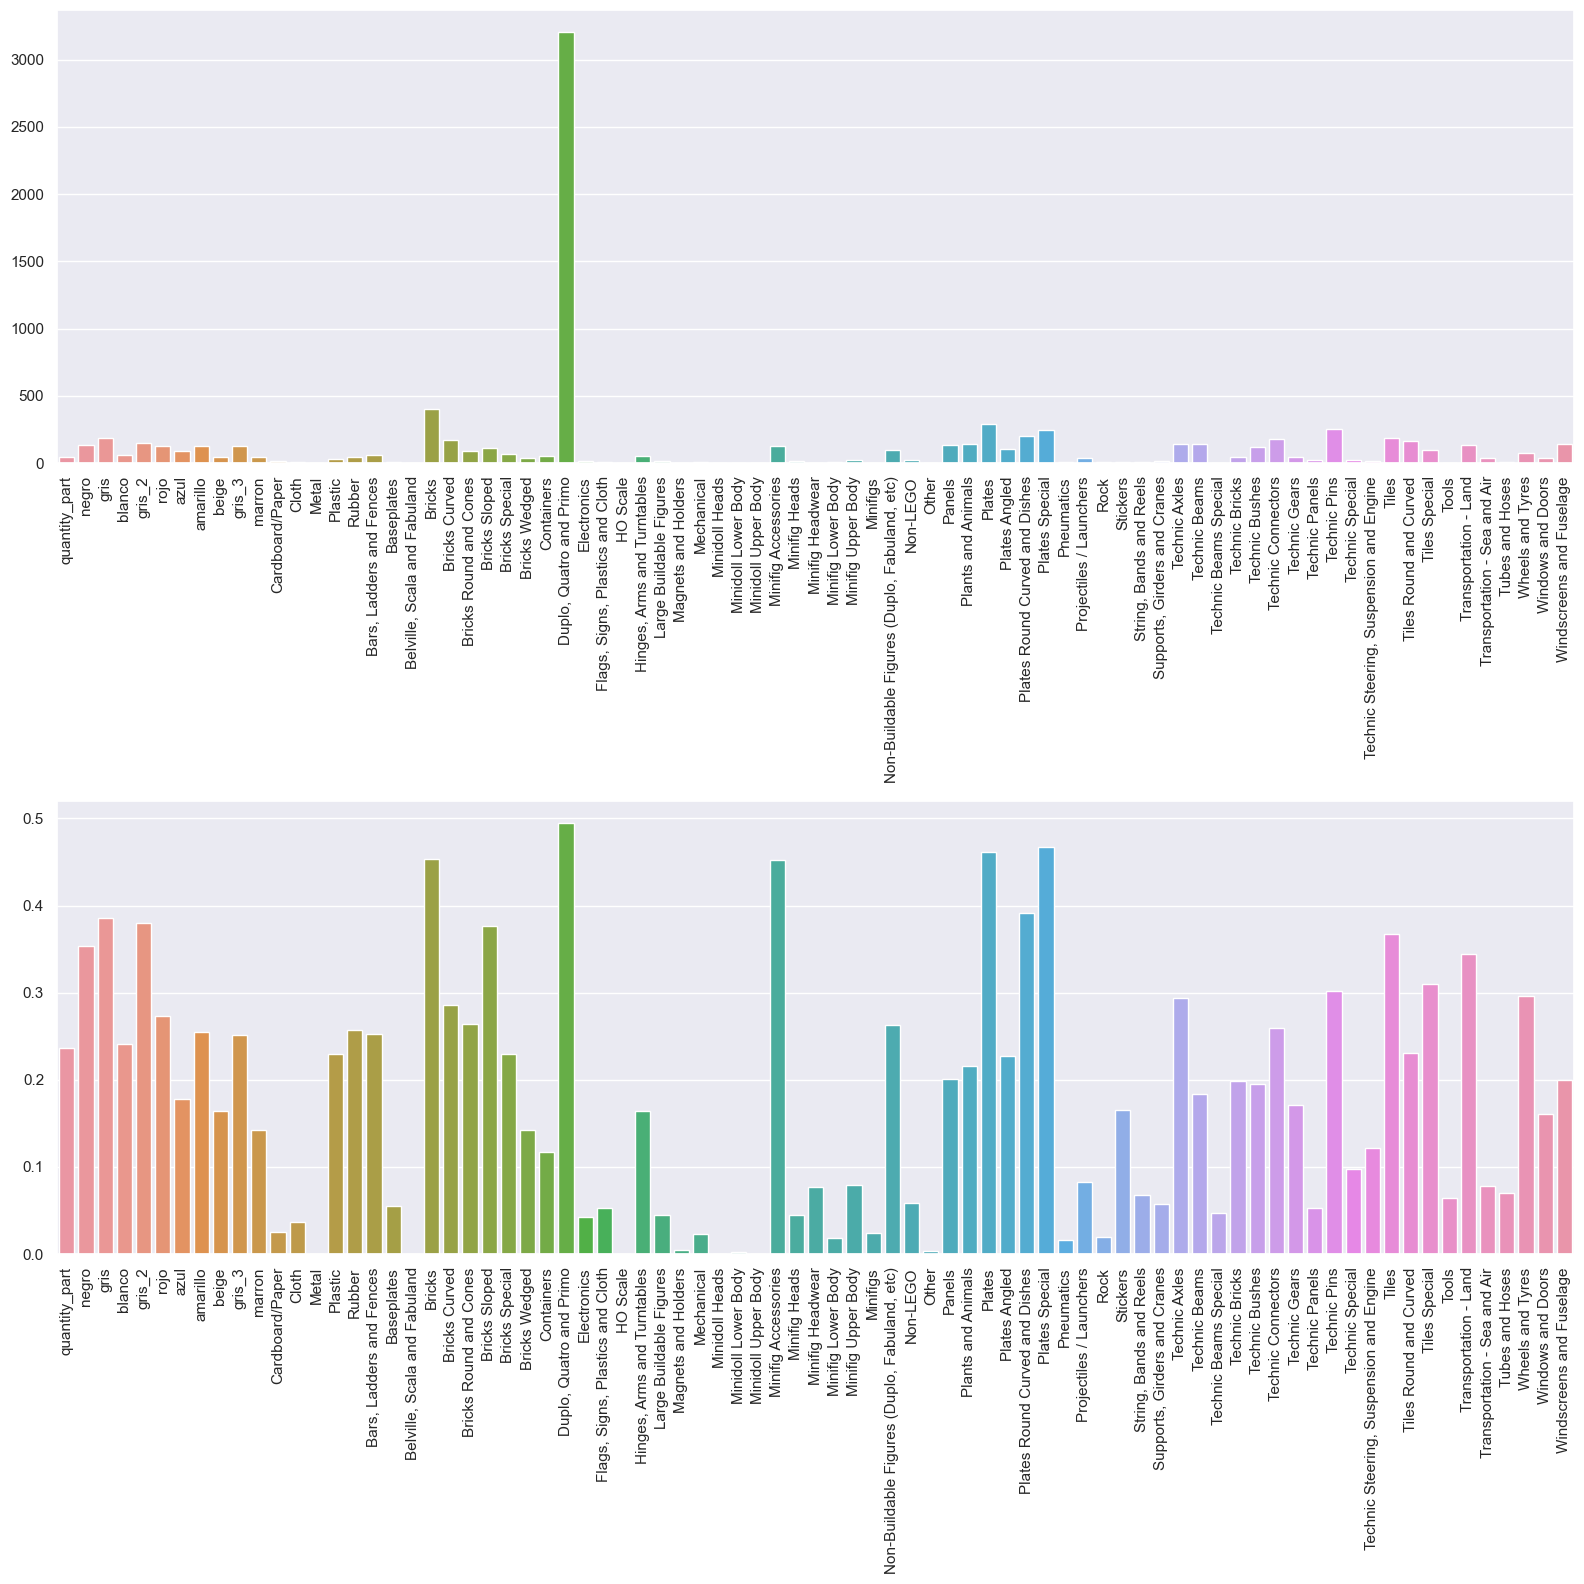

In [119]:
def select_features_anova(X_train, y_train, X_test, k='all'):
    fs = SelectKBest(score_func=f_classif, k=20)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def select_features_mi(X_train, y_train, X_test, k='all'):
    fs = SelectKBest(score_func=mutual_info_classif, k=20)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train_anova, X_test_anova, anova = select_features_anova(X_train, y_train, X_test)
fig, axes = plt.subplots(2, 1, figsize=(16, 16))
sns.barplot(x=df_encoded.columns[:-1].values, y=anova.scores_, ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

X_train_mi, X_test_mi, mi = select_features_mi(X_train, y_train, X_test)
sns.barplot(x=df_encoded.columns[:-1].values, y=mi.scores_, ax=axes[1])
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

In [120]:
# Creo selector de características basado en MI
selector = SelectKBest(score_func=mutual_info_classif, k=20)
selector.fit(X, y_encoded)
feature_scores = selector.scores_
# Combino las variables indep y sus puntuaciones en un df
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores})
# Ordeno el df por puntuación descendente
feature_scores_df = feature_scores_df.sort_values('Score', ascending=False)
# Selecciono las 10 características con las puntuaciones más altas
top_10_features = feature_scores_df.head(20)['Feature'].tolist()
top_10_features

/home/benjas/Documents/gitrepo/AdD/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['Plates Special',
 'Plates',
 'Duplo, Quatro and Primo',
 'Bricks',
 'Minifig Accessories',
 'gris',
 'Plates Round Curved and Dishes',
 'gris_2',
 'Bricks Sloped',
 'negro',
 'Tiles',
 'Transportation - Land',
 'Tiles Special',
 'Technic Pins',
 'Bricks Curved',
 'Technic Axles',
 'Wheels and Tyres',
 'rojo',
 'amarillo',
 'Bricks Round and Cones']

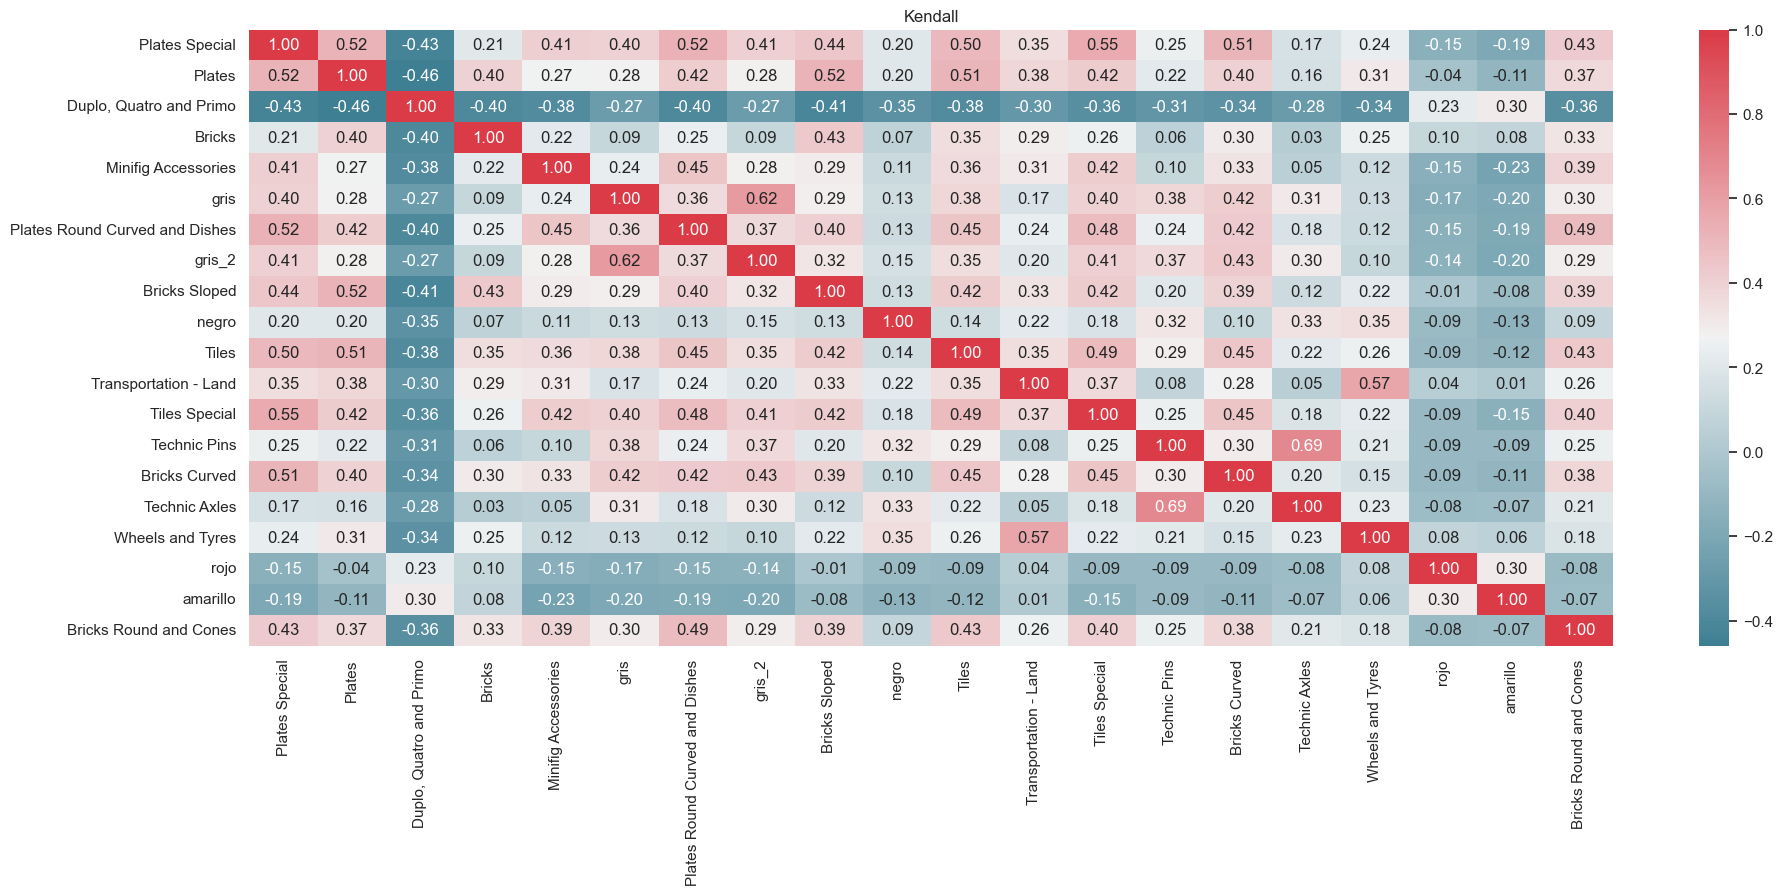

In [121]:
# Kendall b asume que la variable categórica tiene ordinalidad, no es nuestro caso.
fig, axes = plt.subplots(1,1,figsize=(22,8))
tau = df_encoded[top_10_features].corr(method='kendall')
axes.set_title("Kendall")
sns.heatmap(tau, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

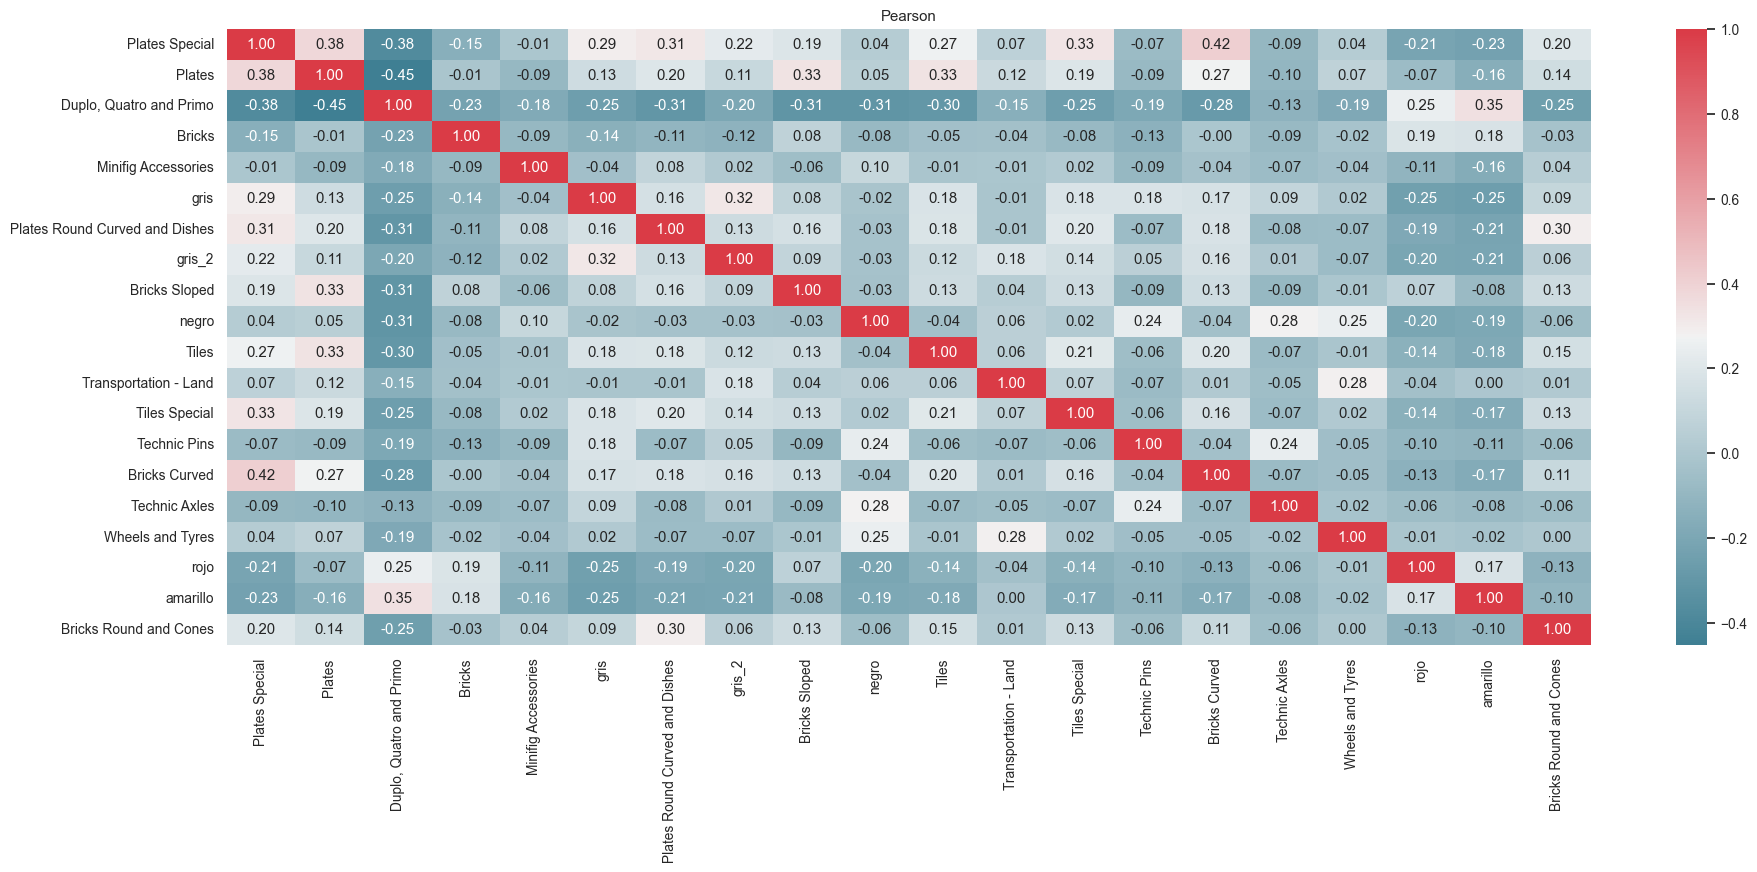

In [122]:
fig, axes = plt.subplots(1, 1, figsize=(22, 8))
axes.set_title("Pearson")
pearson = df_encoded[top_10_features].corr(method='pearson')
sns.heatmap(pearson, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=1)
plt.show()

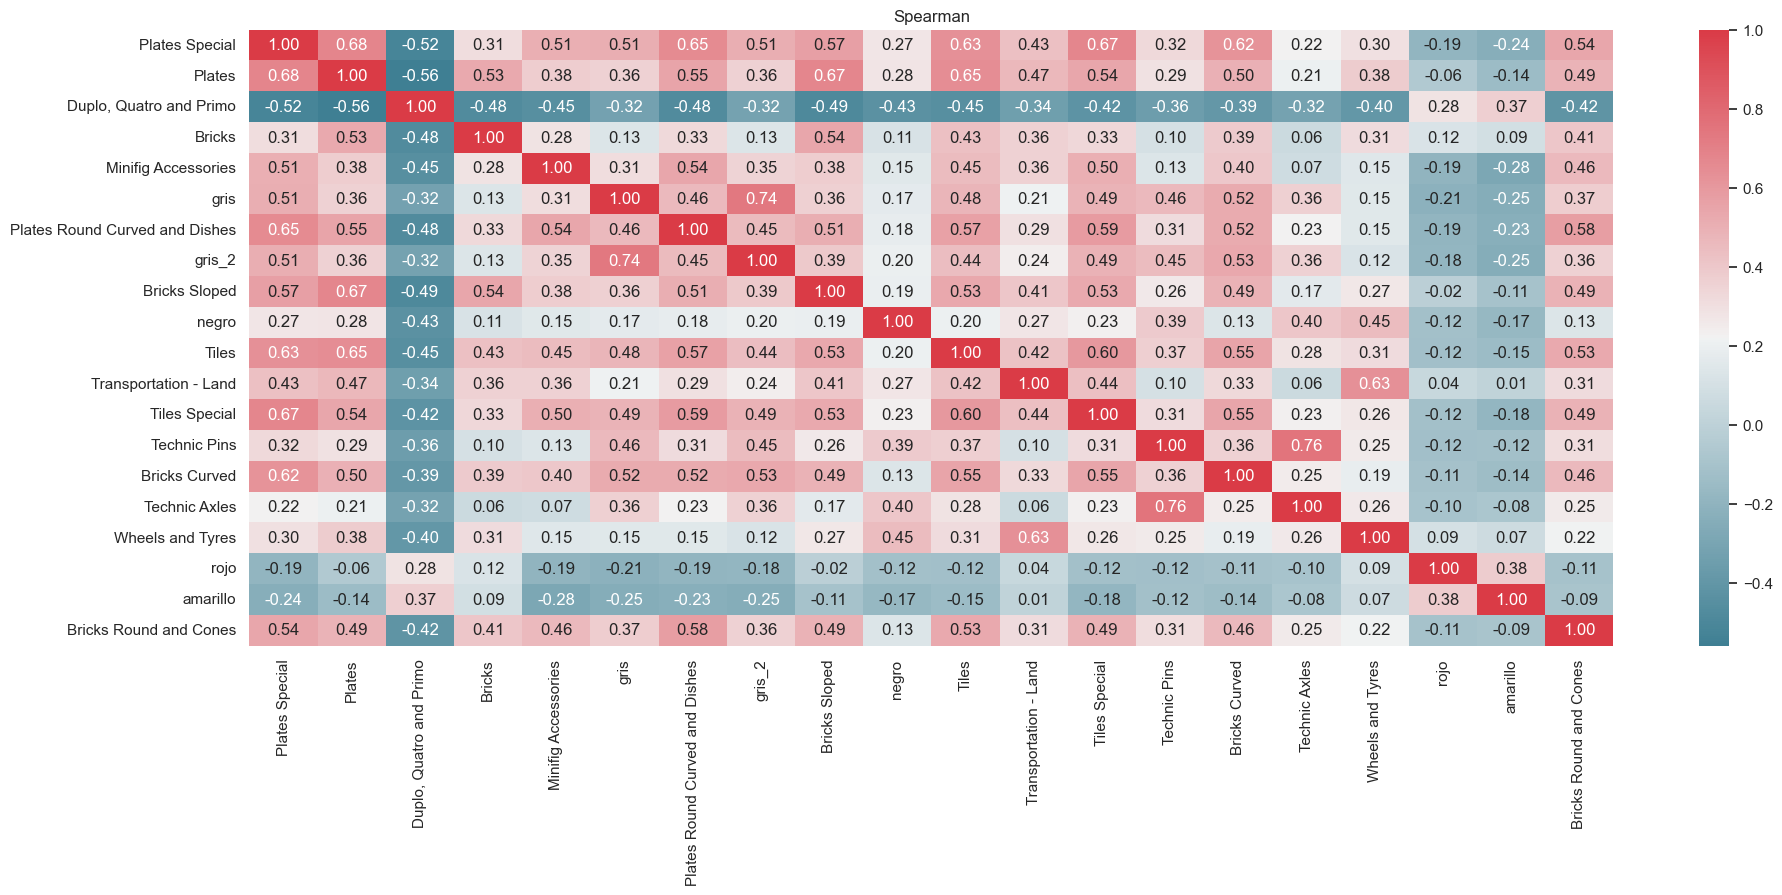

In [123]:
fig, axes = plt.subplots(1, 1, figsize=(22, 8))
axes.set_title("Spearman")
pearson = df_encoded[top_10_features].corr(method='spearman')
sns.heatmap(pearson, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=1)
plt.show()

Número de componentes necesarias para explicar el 80% de la varianza: 49


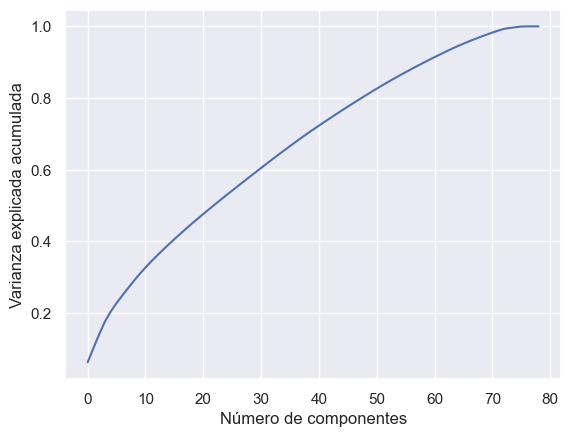

(6732, 49)


In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# 1. Aplicar PCA (validar que se cumplan las condiciones), ¿Cuántas componentes necesitamos para explicar el 80% de la varianza?
# Estandarización de features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
pca.fit_transform(X_std)
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_sum >= 0.8) + 1
print("Número de componentes necesarias para explicar el 80% de la varianza:", n_components)

# 2. Gráficar la variación acumulada
plt.plot(cumulative_sum)
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.show()

# Aplicación de PCA explicando 80% de la varianza
pca = PCA(n_components=0.8, random_state=123)
X_transformed = pca.fit_transform(X_std)
print(X_transformed.shape)

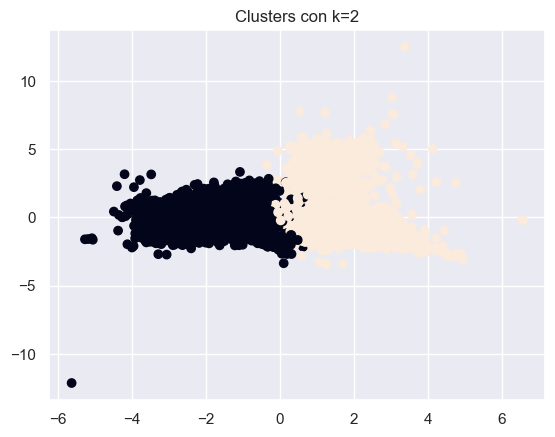

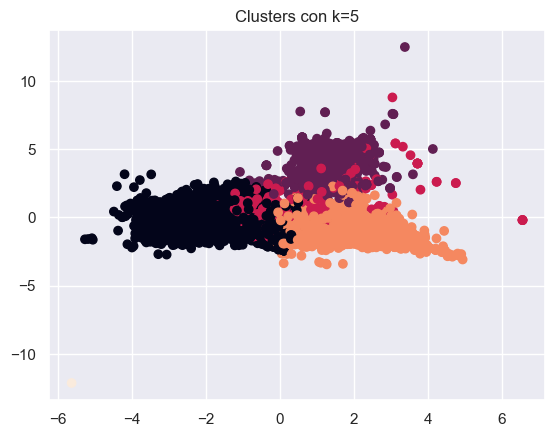

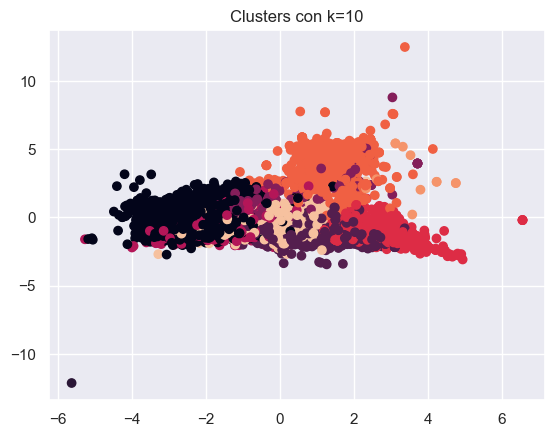

In [125]:
from sklearn.cluster import KMeans
k_values = [2,5,10]

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_transformed)
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels)
    plt.title(f"Clusters con k={k}")
    plt.show()

In [126]:
pca = PCA(n_components=2, random_state=123)
X_transformed = pca.fit_transform(X_std)
print(X_transformed.shape)
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
cumulative_sum

# 2 componentes explican solo 10% de la variabilidad en los datos

(6732, 2)


array([0.06167449, 0.10166013])

## 5. Licencia
Este proyecto se encuentra publicado bajo la licencia MIT. En [este enlace](https://opensource.org/licenses/MIT) podrá encontrar más información sobre la misma.